In [9]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal, Optional, List
from IPython.display import Image, display
from datetime import datetime

In [ ]:
# Define the state
class SupportState(TypedDict):
    user_id: str
    message: str
    sentiment: Optional[Literal["positive", "neutral", "negative", "urgent"]]
    category: Optional[Literal["billing", "technical", "account", "product"]]
    priority: Optional[Literal["low", "medium", "high", "critical"]]
    context: Optional[List[str]]  # Previous conversation history
    response: Optional[str]
    escalate: bool
    requires_human: bool
    ticket_id: Optional[str]

## Nodes ##


In [ ]:

def analyze_sentiment(state: SupportState):
    """Analyze message sentiment and urgency"""
    msg = state["message"].lower()
    
    # Check for urgent keywords
    urgent_keywords = ["urgent", "asap", "immediately", "emergency", "critical", "not working"]
    negative_keywords = ["angry", "frustrated", "disappointed", "terrible", "worst", "bad"]
    
    if any(word in msg for word in urgent_keywords):
        sentiment = "urgent"
    elif any(word in msg for word in negative_keywords):
        sentiment = "negative"
    elif any(word in msg for word in ["thank", "great", "love", "awesome"]):
        sentiment = "positive"
    else:
        sentiment = "neutral"
    
    return {"sentiment": sentiment}


def categorize_issue(state: SupportState):
    """Categorize the support request"""
    msg = state["message"].lower()
    
    if any(word in msg for word in ["bill", "charge", "payment", "refund", "invoice"]):
        category = "billing"
    elif any(word in msg for word in ["bug", "error", "crash", "not working", "broken"]):
        category = "technical"
    elif any(word in msg for word in ["login", "password", "access", "account", "reset"]):
        category = "account"
    else:
        category = "product"
    
    return {"category": category}


def assign_priority(state: SupportState):
    """Assign priority based on sentiment and category"""
    sentiment = state["sentiment"]
    category = state["category"]
    
    # Critical: urgent sentiment OR billing + negative
    if sentiment == "urgent" or (category == "billing" and sentiment == "negative"):
        priority = "critical"
    # High: negative sentiment OR technical issues
    elif sentiment == "negative" or category == "technical":
        priority = "high"
    # Medium: neutral technical or account issues
    elif category in ["technical", "account"] and sentiment == "neutral":
        priority = "medium"
    else:
        priority = "low"
    
    return {"priority": priority}


def check_knowledge_base(state: SupportState):
    """Check if we can auto-resolve from knowledge base"""
    category = state["category"]
    priority = state["priority"]
    
    # Auto-resolve conditions:
    # - Low/medium priority
    # - Account or product categories (not billing/technical critical issues)
    can_auto_resolve = (
        priority in ["low", "medium"] and 
        category in ["account", "product"]
    )
    
    if can_auto_resolve:
        return {
            "response": f"Auto-resolved {category} issue from knowledge base",
            "requires_human": False
        }
    else:
        return {"requires_human": True}


def generate_ai_response(state: SupportState):
    """Generate AI-powered response for medium complexity issues"""
    return {
        "response": f"AI-generated response for {state['category']} issue (Priority: {state['priority']})",
        "escalate": state["priority"] == "critical"
    }


def escalate_to_human(state: SupportState):
    """Route to human agent"""
    ticket_id = f"TKT-{datetime.now().strftime('%Y%m%d%H%M%S')}"
    return {
        "response": f"Escalated to human agent - Ticket: {ticket_id}",
        "ticket_id": ticket_id,
        "escalate": True
    }


def send_automated_response(state: SupportState):
    """Send quick automated response"""
    return {
        "response": f"Automated response for {state['category']} query",
        "escalate": False
    }

# Routes #

In [12]:
def should_auto_resolve(state: SupportState) -> str:
    """Decide if we can auto-resolve or need AI/human"""
    if not state.get("requires_human"):
        return "automated"
    elif state["priority"] in ["critical", "high"]:
        return "escalate"
    else:
        return "ai_response"


def should_escalate(state: SupportState) -> str:
    """Decide if AI response should be escalated"""
    if state.get("escalate"):
        return "escalate"
    else:
        return "end"


# Build the workflow #

In [13]:
workflow = StateGraph(SupportState)

# Add all nodes
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("categorize", categorize_issue)
workflow.add_node("assign_priority", assign_priority)
workflow.add_node("check_knowledge_base", check_knowledge_base)
workflow.add_node("ai_response", generate_ai_response)
workflow.add_node("escalate", escalate_to_human)
workflow.add_node("automated", send_automated_response)


# Define the flow #

In [14]:
workflow.set_entry_point("analyze_sentiment")

# Sequential processing
workflow.add_edge("analyze_sentiment", "categorize")
workflow.add_edge("categorize", "assign_priority")
workflow.add_edge("assign_priority", "check_knowledge_base")

# Conditional Checks #


In [15]:
# Conditional routing after Knowledge Base check
workflow.add_conditional_edges(
    "check_knowledge_base",
    should_auto_resolve,
    {
        "automated": "automated",
        "ai_response": "ai_response",
        "escalate": "escalate"
    }
)

# AI response may need escalation
workflow.add_conditional_edges(
    "ai_response",
    should_escalate,
    {
        "escalate": "escalate",
        "end": END
    }
)



# End of Nodes #

In [16]:
workflow.add_edge("automated", END)
workflow.add_edge("escalate", END)

graph = workflow.compile()


# Visualize 

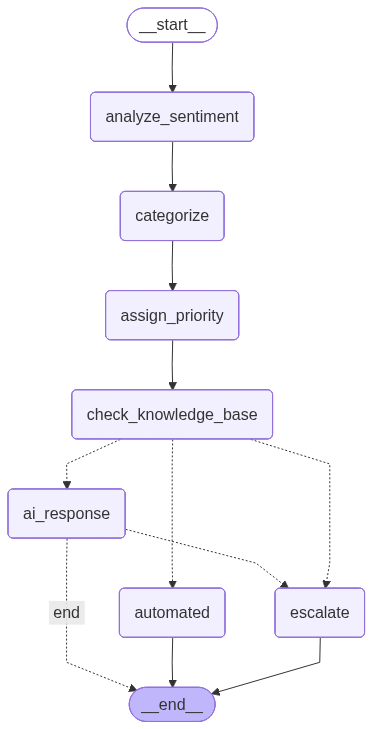

In [17]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


# Test the module #

In [18]:
test_cases = [
    {
        "user_id": "U123",
        "message": "URGENT: Cannot access my account, need help immediately!",
        "context": []
    },
    {
        "user_id": "U456", 
        "message": "How do I reset my password?",
        "context": []
    },
    {
        "user_id": "U789",
        "message": "I'm very frustrated with the billing charges, this is terrible!",
        "context": []
    }
]

print("\n" + "="*60)
print("TESTING WORKFLOW")
print("="*60)

for i, test in enumerate(test_cases, 1):
    print(f"\n🧪 Test Case {i}:")
    print(f"   Message: {test['message']}")
    result = graph.invoke(test)
    print(f"   → Sentiment: {result.get('sentiment')}")
    print(f"   → Category: {result.get('category')}")
    print(f"   → Priority: {result.get('priority')}")
    print(f"   → Response: {result.get('response')}")
    if result.get('ticket_id'):
        print(f"   → Ticket: {result.get('ticket_id')}")


TESTING WORKFLOW

🧪 Test Case 1:
   Message: URGENT: Cannot access my account, need help immediately!
   → Sentiment: urgent
   → Category: account
   → Priority: critical
   → Response: Escalated to human agent - Ticket: TKT-20251010123922
   → Ticket: TKT-20251010123922

🧪 Test Case 2:
   Message: How do I reset my password?
   → Sentiment: neutral
   → Category: account
   → Priority: medium
   → Response: Automated response for account query

🧪 Test Case 3:
   Message: I'm very frustrated with the billing charges, this is terrible!
   → Sentiment: negative
   → Category: billing
   → Priority: critical
   → Response: Escalated to human agent - Ticket: TKT-20251010123922
   → Ticket: TKT-20251010123922
